# Group level statistics


## Retrieving First-Level results
As we now have the same contrast results from multiple `subjects`, we can define our `group level model`. First, we need to gather the `individual contrast maps`.

In [5]:
import os
from bids.layout import BIDSLayout

ds_path = '../data'
results_path = '../results'

# Initialize the BIDS layout and include the derivatives in it
layout = BIDSLayout(ds_path, derivatives = True)

# Attach the results folder to the layout. It must complay with BIDS standards. 
# And must include dataset_description.json file!
layout.add_derivatives(os.path.join(results_path, "first-level"))

We will collect individual t-maps (`stat`) that represent the BOLD activity estimate divided by the uncertainty about this estimate. 

We will first look at only the **Faces > Scrambled** contrast. 

In [9]:
contrast = 'FacesScrambled'
stat_files = layout.get(desc = contrast, suffix='z', extension = '.nii.gz', return_type='filename')
print(*stat_files, sep = "\n")

/imaging/correia/da05/workshops/2024-CBU/notebooks/../results/first-level/sub-01/sub-01_task-facerecognition_desc-FacesScrambled_z.nii.gz
/imaging/correia/da05/workshops/2024-CBU/notebooks/../results/first-level/sub-02/sub-02_task-facerecognition_desc-FacesScrambled_z.nii.gz
/imaging/correia/da05/workshops/2024-CBU/notebooks/../results/first-level/sub-03/sub-03_task-facerecognition_desc-FacesScrambled_z.nii.gz
/imaging/correia/da05/workshops/2024-CBU/notebooks/../results/first-level/sub-04/sub-04_task-facerecognition_desc-FacesScrambled_z.nii.gz
/imaging/correia/da05/workshops/2024-CBU/notebooks/../results/first-level/sub-05/sub-05_task-facerecognition_desc-FacesScrambled_z.nii.gz
/imaging/correia/da05/workshops/2024-CBU/notebooks/../results/first-level/sub-06/sub-06_task-facerecognition_desc-FacesScrambled_z.nii.gz
/imaging/correia/da05/workshops/2024-CBU/notebooks/../results/first-level/sub-07/sub-07_task-facerecognition_desc-FacesScrambled_z.nii.gz
/imaging/correia/da05/workshops/20

We will want to display subject ID on top of their individual t-maps. Therefore we need to link each stat file with the corresponding subject ID. The simplest seems to retrieve the subject list from the BIDS layout.

In [7]:
subjects = layout.get_subjects()
print(subjects)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16']


## Displaying subject t-maps

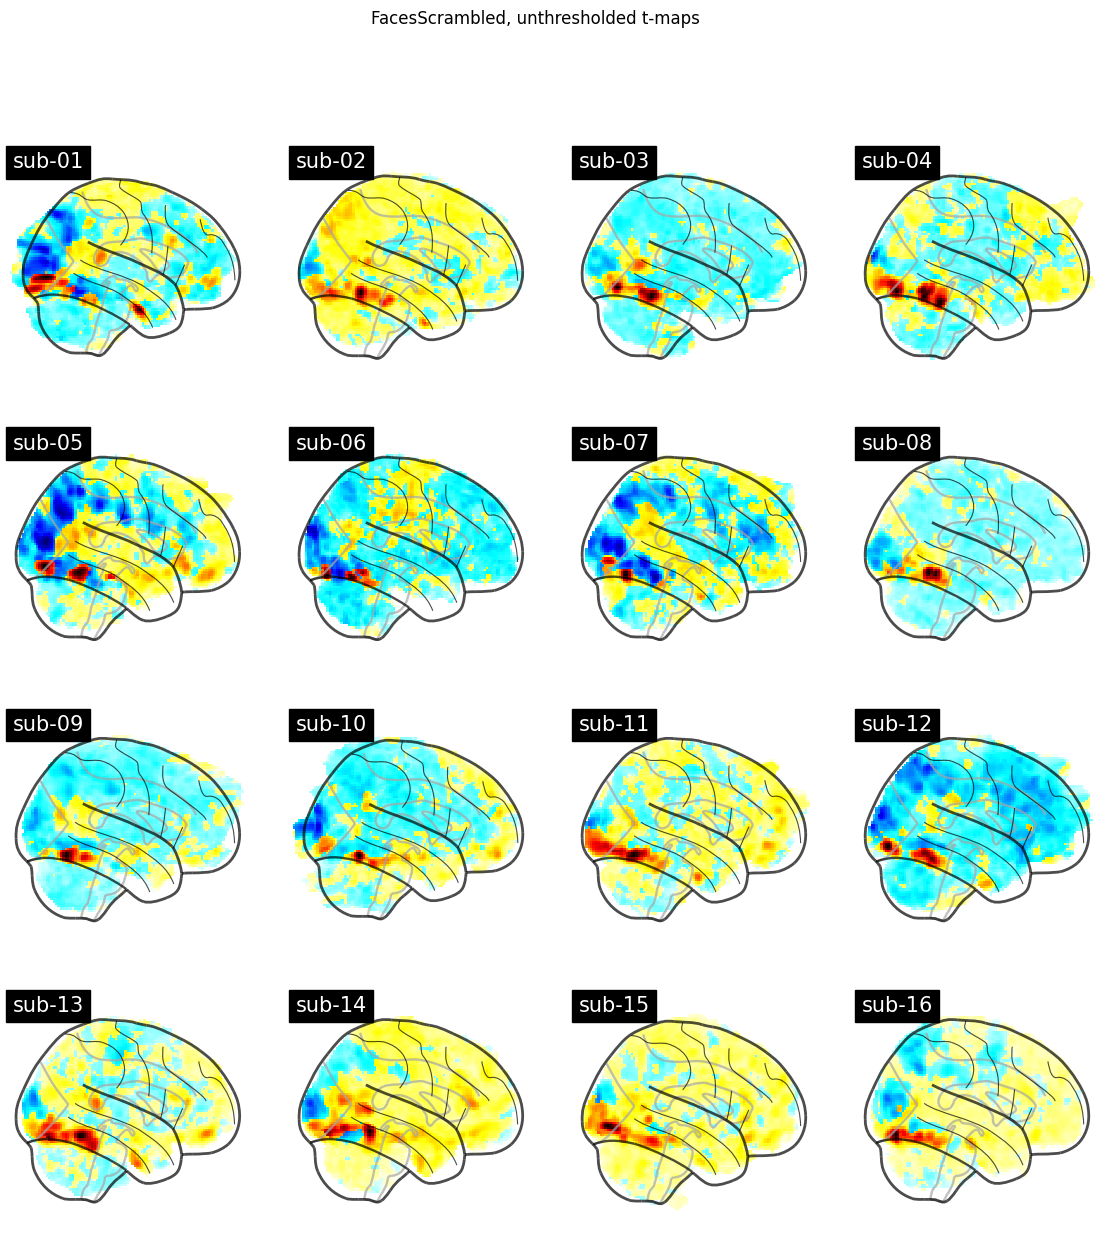

In [10]:
from nilearn import plotting
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(14, 14))

for i, stat_map in enumerate(stat_files):
    plotting.plot_glass_brain(stat_map, 
                              title = 'sub-' + subjects[i],
                              axes = axes[int(i / 4), int(i % 4)],
                              plot_abs = False, 
                              display_mode='x')
fig.suptitle(contrast + ', unthresholded t-maps')
plotting.show()

## Estimate second level model

### Design matrix

The next step includes the definition of a `design matrix`. Here we will want to run a simple `one-sample t-test`. We just need to indicate as many `1` as we have subjects with first-level results.

In [5]:
import pandas as pd
design_matrix = pd.DataFrame(
    [1] * len(stat_files),
    columns=['intercept'])
design_matrix

,intercept
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


### Model specification and fit

In [6]:
from nilearn.glm.second_level import SecondLevelModel

second_level_model = SecondLevelModel()
second_level_model = second_level_model.fit(
    stat_files,
    design_matrix = design_matrix)

In [7]:
# https://nilearn.github.io/dev/auto_examples/05_glm_second_level/plot_second_level_one_sample_test.html#sphx-glr-auto-examples-05-glm-second-level-plot-second-level-one-sample-test-py

from nilearn.glm.second_level import non_parametric_inference

out_dict = non_parametric_inference(
    stat_files,
    design_matrix=design_matrix,
    model_intercept=True,
    n_perm=10000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=False,
    n_jobs=12,
    threshold=0.001, # cluster level threshold
)

/home/da05/.conda/envs/fMRI/lib/python3.10/site-packages/nilearn/mass_univariate/permuted_least_squares.py:993: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/home/da05/.conda/envs/fMRI/lib/python3.10/site-packages/nilearn/masking.py:975: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [8]:
title = ("")
plotting.plot_stat_map(
    out_dict,
    colorbar=True,
    threshold=-np.log10(0.05),
    title=title,
)
plotting.show()

ValueError: File not found: 't'

In [ ]:
title = ("")
plotting.plot_stat_map(
    out_dict,
    colorbar=True,
    threshold=-np.log10(0.1),
    title=title,
)
plotting.show()

In [ ]:
-np.log10(0.05)

In [ ]:
plotting.plot_stat_map(out_dict['logp_max_t'],
                       threshold=-np.log10(0.05),
                       title='Permutation Test\n(Voxel-Level Error Control)')

In [ ]:
from atlasreader import create_output

# generate and save also atlasreader output
create_output(
    out_dict['logp_max_t'], 
    cluster_extent = 20, 
    voxel_thresh = -np.log10(0.05),
    direction = 'pos',
    outdir = None
)


### Contrast estimation

In [9]:
z_map = second_level_model.compute_contrast(output_type='z_score')

In [10]:
import numpy as np
from nilearn.maskers import NiftiMasker

stat_img = z_map
masker = NiftiMasker(mask_strategy="background").fit(stat_img)
stats = np.ravel(masker.transform(stat_img))
n_voxels = np.size(stats)

In [11]:
from scipy.stats import norm
threshold = norm.isf(0.05/ n_voxels)
print(n_voxels)
print(threshold)

243593
5.064013374886163


In [12]:
from scipy.stats import t

# Degrees of freedom
df = 15

# P-value
p_value = 0.000000205260414

# Calculate the t-value
t_value = t.ppf(1 - p_value/2, df)

print("t-value:", t_value)


t-value: 8.968087390018104


In [13]:
from nilearn.glm.thresholding import threshold_stats_img

### Thresholding and plotting

Uncorrected p<.001 threshold: 3.090


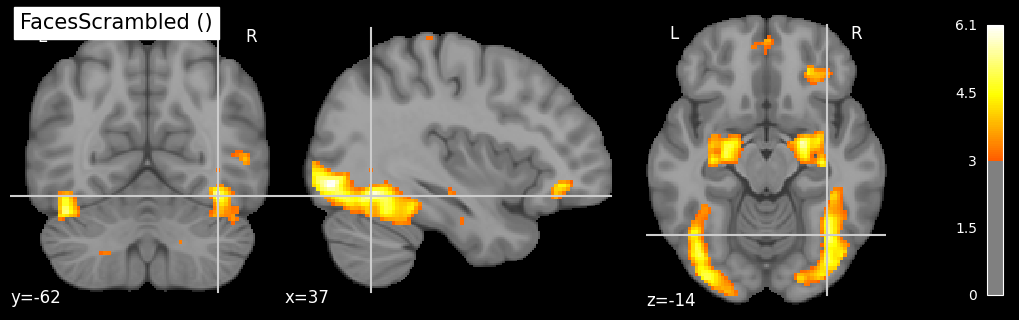

In [14]:
from nilearn.glm.thresholding import threshold_stats_img

cluster_map, threshold = threshold_stats_img(
    z_map, alpha=0.001, 
    height_control='fpr', 
    cluster_threshold=0,
    two_sided=False)

# displaying on mni152 template brain
from nilearn.datasets import load_mni152_template
template = load_mni152_template()

print('Uncorrected p<.001 threshold: %.3f' % threshold)
plotting.plot_stat_map(
    cluster_map, 
    threshold = threshold,       
    display_mode = 'ortho',
    cut_coords = [37,-62,-14],
    black_bg = True,
    bg_img = template,
    title = contrast + ' ()')

fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

FWE p<.05 threshold: 5.064


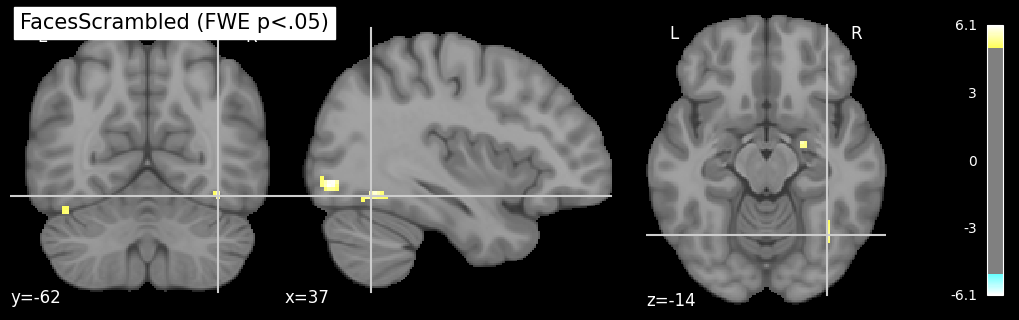

In [15]:
_, threshold = threshold_stats_img(
    z_map, alpha=0.05, 
    height_control='bonferroni', 
    cluster_threshold=0,
    two_sided=False)

from nilearn.datasets import load_mni152_template
template = load_mni152_template()

print('FWE p<.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(
    z_map, 
    threshold = threshold,       
    display_mode = 'ortho',
    cut_coords = [37,-62,-14],
    black_bg = True,
    bg_img = template,
    title = contrast + ' (FWE p<.05)')

fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

In [ ]:
z_map.to_filename('z_score.nii.gz')

We can also look at a 3D brain using `plotly`.

In [ ]:
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()

_, threshold = threshold_stats_img(
    z_map, alpha = 0.001, 
    height_control = 'fpr',
    two_sided = True)

view = plotting.view_img_on_surf(z_map, threshold=threshold)
# view.open_in_browser()
view

Let's get some more summary results. Here we will get a cluster table. 

In [16]:
from nilearn.reporting import get_clusters_table
get_clusters_table(z_map, threshold, cluster_threshold=20, two_sided=False, min_distance=8.0)

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,37.5,-84.5,-8.5,6.054958,1240
1,1a,29.5,-90.5,-6.5,5.971392,
2,2,-32.5,-92.5,-8.5,5.686933,360


Can create more complete reports with [nilearn.reporting](https://nilearn.github.io/dev/modules/generated/nilearn.reporting.make_glm_report.html).

In [ ]:

"""from nilearn.reporting import make_glm_report

report = make_glm_report(model = second_level_model,
                         contrasts = 'intercept',
                         threshold = threshold,
                         cluster_threshold = 20,
                         display_mode = 'ortho'
                         )

report
"""

Or we can use ['atlasreader'](https://github.com/miykael/atlasreader) package, as demonstrated in the below script to create reports for all our contrasts. 

## Second level for multiple contrasts

The script below will generate outputs of group-level results for multiple contrasts. 

In this example, we want to threshold the results to **Family-wise error corrected at p < .05**. 

In addition to getting our result maps, we will use *atlasreader* to generate result tables and peak cluster images. 

In [22]:
import warnings;
warnings.filterwarnings('ignore');

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# ======================================================================
# Dace Apšvalka (MRC CBU 2022)
# Group level fMRI analysis using Nilearn
# ======================================================================

# ======================================================================
# IMPORT RELEVANT PACKAGES
# ======================================================================
import os
import numpy as np
import pandas as pd
from bids.layout import BIDSLayout
from nilearn.datasets import load_mni152_template
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.thresholding import threshold_stats_img
from nilearn.reporting import get_clusters_table
from atlasreader import create_output


# ======================================================================
# WHICH CONTRASTS
# ======================================================================
contrasts = {'FamousUnfamiliar': 'Famous > Unfamiliar',
             'UnfamiliarFamous': 'Unfamiliar > Famous',
             'FacesScrambled': 'Faces > Scrambled',
             'ScrambledFaces': 'Scrambled > Faces'}
# ======================================================================
# WHAT THRESHOLD
# ======================================================================
height_control ='bonferroni' # bonferroni is FWE; fpr is uncorrected
alpha = .05
cluster_threshold = 0

# ======================================================================
# DEFINE PATHS
# ======================================================================
ds_path = '/imaging/correia/da05/workshops/2023-09-COGNESTIC/demo/FaceRecognition/'

outdir = os.path.join(ds_path, 'results', 'group-level_fixed-slicetime_' + height_control + str(alpha)[2:] + 'k' + \
                      str(cluster_threshold))
if not os.path.exists(outdir):
    os.makedirs(outdir)
                      
# ======================================================================
# PREPARE OTHER SUFF
# ======================================================================

# Initialize the BIDS layout and include the derivatives in it
layout = BIDSLayout(os.path.join(ds_path, 'data/bids'), derivatives=True)
layout.add_derivatives(os.path.join(ds_path, "results", "first-level_fixed_slicetime"))

# load a template to resample images to if needed
template = load_mni152_template()

# ======================================================================
# PERFORM GROUP LEVEL ANALYSIS PER CONTRAST
# ======================================================================

for contrast_id, contrast_val in contrasts.items():
    # get the first level result maps
    stat_files = layout.get(desc = contrast_id, suffix = 'stat', return_type='filename', extension = '.nii.gz')
    
    # generate the result file name
    result_name = 'group_zmap_' + contrast_id
    
    # create the group level design matrix. Here just a one-sample t-test
    design_matrix = pd.DataFrame([1] * len(stat_files),
                                 columns=['intercept'])
    
    # define and compute the glm
    second_level_model = SecondLevelModel()
    second_level_model = second_level_model.fit(
        stat_files,
        design_matrix = design_matrix)
    
    # get the z-map for the contrast of interest
    z_map = second_level_model.compute_contrast(output_type='z_score')
        
    # threshold the z-map
    thresholded_map, threshold = threshold_stats_img(
        z_map, 
        alpha = alpha,
        height_control = height_control,
        two_sided = True,
        cluster_threshold = cluster_threshold)
    
    # get peaks   
    peaks = get_clusters_table(thresholded_map, stat_threshold=threshold)
    
    # if there is any peak then save the map and generate report
    if len(peaks) != 0:
        print('Creating output for', contrast_val)
        fname = os.path.join(outdir, result_name + '.nii.gz')
        thresholded_map.to_filename(fname)

        # generate and save also atlasreader output
        create_output(
            fname, 
            cluster_extent = cluster_threshold, 
            voxel_thresh = threshold,
            direction = 'pos',
            outdir = os.path.join(outdir, 'atlasreader', contrast_id)
        )
    else:
        print('No significant voxels for', contrast_val)

print('done')

No significant voxels for Famous > Unfamiliar
No significant voxels for Unfamiliar > Famous
Creating output for Faces > Scrambled
No significant voxels for Scrambled > Faces
done


### Summary results for FWE, p < .05, k=0

Let's now loop through the generated output and display the peak image and results table for each contrast.

Famous > Unfamiliar does not have significant results
Unfamiliar > Famous does not have significant results
Results for Faces > Scrambled


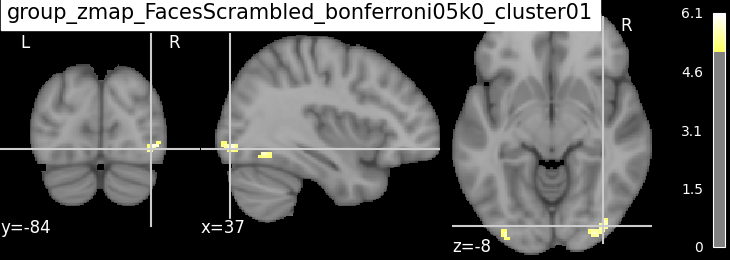

,cluster_id,peak_x,peak_y,peak_z,peak_value,volume_mm,aal,desikan_killiany,harvard_oxford
0,1.0,37.5,-84.5,-8.5,6.120899,1120.0,Occipital_Inf_R,Right-Cerebral-White-Matter,48.0% Right_Lateral_Occipital_Cortex_inferior_...
1,2.0,-32.5,-92.5,-8.5,5.602977,200.0,Occipital_Inf_L,Left-Cerebral-White-Matter,49.0% Left_Occipital_Pole; 21.0% Left_Lateral_...
2,3.0,37.5,-60.5,-12.5,5.820808,80.0,Fusiform_R,Right-Cerebral-White-Matter,23.0% Right_Temporal_Occipital_Fusiform_Cortex...
3,4.0,39.5,-52.5,-20.5,5.395194,56.0,Fusiform_R,ctx-rh-fusiform,77.0% Right_Temporal_Occipital_Fusiform_Cortex
4,5.0,23.5,-6.5,-12.5,5.433008,32.0,Amygdala_R,Right-Amygdala,90.0% Right_Amygdala
5,6.0,-42.5,-60.5,-22.5,5.531599,16.0,Fusiform_L,Unknown,38.0% Left_Temporal_Occipital_Fusiform_Cortex;...


Results for Scrambled > Faces


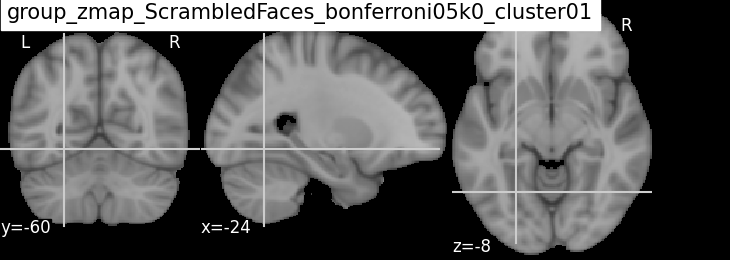

,cluster_id,peak_x,peak_y,peak_z,peak_value,volume_mm,aal,desikan_killiany,harvard_oxford
0,1.0,-24.5,-60.5,-8.5,5.210613,8.0,Lingual_L,Left-Cerebral-White-Matter,35.0% Left_Lingual_Gyrus; 21.0% Left_Temporal_...


In [18]:
import glob
from IPython.display import Image

contrasts = {'FamousUnfamiliar': 'Famous > Unfamiliar',
             'UnfamiliarFamous': 'Unfamiliar > Famous',
             'FacesScrambled': 'Faces > Scrambled',
             'ScrambledFaces': 'Scrambled > Faces'}

for contrast_id, contrast_val in contrasts.items():
    # results folder
    results_dir = os.path.join(ds_path, 'results', 'group-level_bonferroni05k0', 'atlasreader', contrast_id)
    
    # if the directory exists
    if os.path.exists(results_dir):
        print('Results for', contrast_val)
        
        # find the image file        
        cluster1 = glob.glob(os.path.join(results_dir, '*cluster01.png'))        
        # find peak table
        peaks = glob.glob(os.path.join(results_dir, '*_peaks.csv'))
        
        # display the image
        display(Image(cluster1[0]))
        # display the table
        display(pd.read_csv(peaks[0]))
    else:
        print(contrast_val, 'does not have significant results')
            


### Summary for unc. p < .001, k=20

Earlier I have also generated results for *'unc. p < .001, k=20'* and saved it in *group-level_fpr001k20* folder. Let's display these results as well. 

In [ ]:
contrasts = {'FamousUnfamiliar': 'Famous > Unfamiliar',
             'UnfamiliarFamous': 'Unfamiliar > Famous',
             'FacesScrambled': 'Faces > Scrambled',
             'ScrambledFaces': 'Scrambled > Faces'}

for contrast_id, contrast_val in contrasts.items():
    # results folder
    results_dir = os.path.join(ds_path, 'results', 'group-level_bonferroni05k0', 'atlasreader', contrast_id)
    
    # if the directory exists
    if os.path.exists(results_dir):
        print('Results for', contrast_val)
        
        # find the image file        
        cluster1 = glob.glob(os.path.join(results_dir, '*cluster01.png'))        
        # find peak table
        peaks = glob.glob(os.path.join(results_dir, '*_peaks.csv'))
        
        # display the image
        display(Image(cluster1[0]))
        # display the table
        display(pd.read_csv(peaks[0]))
    else:
        print(contrast_val, 'do not have significant results')